In [1]:
# -*- coding: utf-8 -*-
"""Interpret_script_Main.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1cBDzzzwdyBp-bpxR_wvVzVlxrbSwrbiG

## Clone GitHub
"""
#
# !git clone https://github.com/Jathurshan0330/Cross-Modal-Transformer.git
#
# cd  /content/Cross-Modal-Transformer
#
# """## Install Requirements"""
#
# !pip install numpy
# !pip install matplotlib
# !pip install h5py
# !pip install einops
# !pip install mne

import os
import numpy as np
import matplotlib.pyplot as plt
import random
import mne
from mne.datasets.sleep_physionet.age import fetch_data
from data_preparations.epoch_func import signal_extract
from datetime import date

import torch
from torchvision import transforms, datasets
from torch.utils import data
from torch.utils.data import Dataset, DataLoader

from pylab import mpl

# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["SimHei"]
# Select Data using mne
# ignore_data = [[13,2],[36,1],[39,1],[39,2],[52,1],[68,1],[68,2], [69,1],[69,2],[78,1],[78,2],[79,1],[79,2]]
subject_no = [
    38]  ### Include the No of subject of interest in Sleepedf Dataset.   Use [38] - SC4381 to reproduce Fig 6 in the revised paper
days = [1]  ### Include the day of the recording. Use [1] to reproduce Fig 6 in the revised paper
start_time_point = 38820  ### Set the time point in the signal to visualize.  ( For figure 6 in the paper Subject 38 Day 1 Start time point 38820)


# Extract dataset and convert it to the suitable format to feed to the model
def new_signal_extract(path_1, path_2, channel='eeg1', filter=True, freq=[0.2, 40]):
    ignore_data = [[13, 2], [36, 1], [39, 1], [39, 2], [52, 1], [68, 1], [68, 2], [69, 1], [69, 2], [78, 1], [78, 2],
                   [79, 1], [79, 2]]
    all_channels = (
        'EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Resp oro-nasal', 'Temp rectal', 'Event marker')

    first_sub_flag = 0
    data = [path_1, path_2]
    print("###########")
    print("Start")
    print(data[0] + " " + data[1])
    print("End")
    print("###########")
    signal2idx = {"eeg1": 0, "eeg2": 1, "eog": 2, "emg": 3}

    all_channels_list = list(all_channels)
    all_channels_list.remove(all_channels[signal2idx[channel]])
    exclude_channels = tuple(all_channels_list)

    sleep_signals = mne.io.read_raw_edf(data[0], verbose=True, exclude=exclude_channels, preload=True)

    annot = mne.read_annotations(data[1])

    ann2label = {"Sleep stage W": 0, "Sleep stage 1": 1, "Sleep stage 2": 2, "Sleep stage 3": 3,
                 "Sleep stage 4": 4, "Sleep stage R": 5}
    #     # "Sleep stage ?": 5,
    #     # "Movement time": 5

    annot.crop(annot[1]['onset'] - 30 * 60,
               annot[-2]['onset'] + 30 * 60)

    sleep_signals.set_annotations(annot, emit_warning=False)

    events, _ = mne.events_from_annotations(
        sleep_signals, event_id=ann2label, chunk_duration=30.)

    # Filtering
    tmax = 30. - 1. / sleep_signals.info['sfreq']

    if filter == True:
        sleep_signals = sleep_signals.copy().filter(l_freq=freq[0], h_freq=freq[1])

    # Breaking into Epochs
    epochs_data = mne.Epochs(raw=sleep_signals, events=events,
                             event_id=ann2label, tmin=0., tmax=tmax, baseline=None, preload=True,
                             on_missing='warn')

    sig_epochs = []
    label_epochs = []

    mean_epochs = []
    std_epochs = []

    signal_mean = np.mean(np.array([epochs_data]))
    signal_std = np.std(np.array([epochs_data]))

    for ep in range(len(epochs_data)):
        for sig in epochs_data[ep]:
            sig_epochs.append(sig)

        sleep_stage = epochs_data[ep].event_id

        if sleep_stage == {"Sleep stage W": 0}:
            label_epochs.append(0)
        if sleep_stage == {"Sleep stage 1": 1}:
            label_epochs.append(1)
        if sleep_stage == {"Sleep stage 2": 2}:
            label_epochs.append(2)
        if sleep_stage == {"Sleep stage 3": 3}:
            label_epochs.append(3)
        if sleep_stage == {"Sleep stage 4": 4}:
            label_epochs.append(3)
        if sleep_stage == {"Sleep stage R": 5}:
            label_epochs.append(4)

        mean_epochs.append(signal_mean)
        std_epochs.append(signal_std)

    sig_epochs = np.array(sig_epochs)
    mean_epochs = np.array(mean_epochs)
    std_epochs = np.array(std_epochs)
    label_epochs = np.array(label_epochs)

    if first_sub_flag == 0:
        main_ext_raw_data = sig_epochs
        main_labels = label_epochs
        main_sub_len = np.array([len(epochs_data)])
        main_mean = mean_epochs
        main_std = std_epochs

    return main_ext_raw_data, main_labels, main_sub_len, main_mean, main_std
def new_signal_extract_2(path_1, channel='eeg1', filter=True, freq=[0.2, 40]):
    ignore_data = [[13, 2], [36, 1], [39, 1], [39, 2], [52, 1], [68, 1], [68, 2], [69, 1], [69, 2], [78, 1], [78, 2],
                   [79, 1], [79, 2]]
    all_channels = ('EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Resp oro-nasal', 'Temp rectal', 'Event marker')

    first_sub_flag = 0
    data = [path_1]
    print("###########")
    print("Start")
    print(data[0])
    print("End")
    print("###########")
    signal2idx = {"eeg1": 0, "eeg2": 1, "eog": 2, "emg": 3}

    all_channels_list = list(all_channels)
    all_channels_list.remove(all_channels[signal2idx[channel]])
    exclude_channels = tuple(all_channels_list)

    sleep_signals = mne.io.read_raw_edf(data[0], verbose=True, exclude=exclude_channels, preload=True)

    print("###########")
    print("Start")
    print(sleep_signals[0])
    print("End")
    print("###########")

    # Filtering
    tmax = 30. - 1. / sleep_signals.info['sfreq']

    if filter == True:
        sleep_signals = sleep_signals.copy().filter(l_freq=freq[0], h_freq=freq[1])

    # Create a time vector for the entire recording
    duration = sleep_signals.times[-1]

    times = np.arange(0, duration, tmax)

    # Create epochs based on时间窗口
    epochs_data = []
    for start_time in times:
        end_time = start_time + tmax
        if end_time > duration:  # 确保 end_time 不超过 duration
            # end_time = duration
            break
        epoch = sleep_signals.copy().crop(tmin=start_time, tmax=end_time)
        epochs_data.append(epoch.get_data())  # 获取epoch数据并转置，确保形状正确

    if len(set([epoch.shape for epoch in epochs_data])) > 1:
        raise ValueError("Epochs must have the same shape.")

    print("###########")
    print("Start")
    print(np.array(epochs_data).shape)
    print("End")
    print("###########")
    print("###########")
    print("Start")
    print(sleep_signals.info)
    print("End")
    print("###########")

    # Convert list of epochs to a MNE EpochsArray object
    # epochs = mne.EpochsArray(np.array(epochs_data), info=sleep_signals.info)
    duration = 30
    epochs = mne.make_fixed_length_epochs(sleep_signals, duration=duration, preload = True)

    print("####################")
    print("Start")
    print(np.array(epochs).shape)
    print("End")
    print("####################")

    # Calculate mean and std of the signal epochs
    signal_mean = np.mean(epochs)
    signal_std = np.std(epochs)

    main_ext_raw_data = epochs.get_data()
    main_sub_len = np.array([len(epochs)])
    main_mean = np.tile(signal_mean, (len(epochs), 1)).squeeze()  # 修改此处，与第二个函数保持一致
    main_std = np.tile(signal_std, (len(epochs), 1)).squeeze()  # 修改此处，与第二个函数保持一致

    return main_ext_raw_data, main_sub_len, main_mean, main_std


path_1 = 'C:\\Users\\Tian_Yumi\\mne_data\\physionet-sleep-data\\SC4381F0-PSG.edf'
path_2 = 'C:\\Users\\Tian_Yumi\\mne_data\\physionet-sleep-data\\SC4381FC-Hypnogram.edf'
eeg1_1,  len_1, eeg1_m1, eeg1_std1 = new_signal_extract_2(path_1, channel='eeg1', filter=True,
                                                                 freq=[0.2, 40])
eog_1, len_1, eog_m1, eog_std1 = new_signal_extract_2(path_1,  channel='eog', filter=True, freq=[0.2, 40])

print(eeg1_1.shape, len_1.shape, eeg1_m1.shape, eeg1_std1.shape)
print(eog_1.shape, len_1.shape, eog_m1.shape, eog_std1.shape)

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("decive: ", device)


class SleepEDF_Seq_MultiChan_Dataset_Inference(Dataset):
    def __init__(self, eeg_file, eog_file,  device, mean_eeg_l=None, sd_eeg_l=None,
                 mean_eog_l=None, sd_eog_l=None, mean_eeg2_l=None, sd_eeg2_l=None, transform=None,
                 target_transform=None, sub_wise_norm=False, num_seq=5):
        """

        """
        # Get the data

        self.eeg = eeg_file
        self.eog = eog_file
        # self.labels = label_file

        # self.labels = torch.from_numpy(self.labels)

        # bin_labels = np.bincount(self.labels)
        # print(f"Labels count: {bin_labels}")
        print(f"Shape of EEG : {self.eeg.shape} , EOG : {self.eog.shape}")  # , EMG: {self.eeg2.shape}")
        # print(f"Shape of Labels : {self.labels.shape}")

        if sub_wise_norm == True:
            print(f"Reading Subject wise mean and sd")

            self.mean_eeg = mean_eeg_l
            self.sd_eeg = sd_eeg_l
            self.mean_eog = mean_eog_l
            self.sd_eog = sd_eog_l

        self.sub_wise_norm = sub_wise_norm
        self.device = device
        self.transform = transform
        self.target_transform = target_transform
        self.num_seq = num_seq

    def __len__(self):
        return  self.num_seq

    def __getitem__(self, idx):
        eeg_data = self.eeg[idx:idx + self.num_seq].squeeze()
        eog_data = self.eog[idx:idx + self.num_seq].squeeze()
        # label = self.labels[idx:idx + self.num_seq, ]

        if self.sub_wise_norm == True:
            eeg_data = (eeg_data - self.mean_eeg[idx]) / self.sd_eeg[idx]
            eog_data = (eog_data - self.mean_eog[idx]) / self.sd_eog[idx]
        elif self.mean and self.sd:
            eeg_data = (eeg_data - self.mean[0]) / self.sd[0]
            eog_data = (eog_data - self.mean[1]) / self.sd[1]
        if self.transform:
            eeg_data = self.transform(eeg_data)
            eog_data = self.transform(eog_data)
        # if self.target_transform:
            # label = self.target_transform(label)
        return eeg_data, eog_data



###########
Start
C:\Users\Tian_Yumi\mne_data\physionet-sleep-data\SC4381F0-PSG.edf C:\Users\Tian_Yumi\mne_data\physionet-sleep-data\SC4381FC-Hypnogram.edf
End
###########
Extracting EDF parameters from C:\Users\Tian_Yumi\mne_data\physionet-sleep-data\SC4381F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8249999  =      0.000 ... 82499.990 secs...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition ba

D:\AIGC\Cross-Modal-Transformer\data_preparations\epoch_func.py:163: RuntimeWarning: No matching events found for Sleep stage 4 (event id 4)
  epochs_data = mne.Epochs(raw=sleep_signals, events=events,


0 bad epochs dropped
(1776, 1, 3000) (1776,) (1,) (1776,) (1776,)
###########
Start
C:\Users\Tian_Yumi\mne_data\physionet-sleep-data\SC4381F0-PSG.edf
End
###########
Extracting EDF parameters from C:\Users\Tian_Yumi\mne_data\physionet-sleep-data\SC4381F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8249999  =      0.000 ... 82499.990 secs...
###########
Start
(array([[ 1.03035409e-05,  2.33692308e-05,  9.35799756e-06, ...,
        -6.63028083e-06, -6.13186813e-07,  2.93003663e-05]]), array([0.000000e+00, 1.000000e-02, 2.000000e-02, ..., 8.249997e+04,
       8.249998e+04, 8.249999e+04]))
End
###########
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower pa

C:\Users\Tian_Yumi\AppData\Local\Temp\ipykernel_26844\1426140370.py:218: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  main_ext_raw_data = epochs.get_data()


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (16.510 s)

###########
Start
(2750, 1, 3000)
End
###########
###########
Start
<Info | 8 non-empty values
 bads: []
 ch_names: EOG horizontal
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 40.0 Hz
 meas_date: 1990-03-26 15:30:00 UTC
 nchan: 1
 projs: []
 sfreq: 100.0 Hz
 subject_info: 4 items (dict)
>
End
###########
Not setting metadata
2750 matching events found
No baseline correction applied
0 projection items activated

C:\Users\Tian_Yumi\AppData\Local\Temp\ipykernel_26844\1426140370.py:218: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  main_ext_raw_data = epochs.get_data()


In [2]:

num_seq = 15
print(eeg1_1.shape,  len_1.shape, eeg1_m1.shape, eeg1_std1.shape)
print(eog_1.shape, len_1.shape, eog_m1.shape, eog_std1.shape)


(2750, 1, 3000) (1,) (2750,) (2750,)
(2750, 1, 3000) (1,) (2750,) (2750,)


Shape of EEG : (2750, 1, 3000) , EOG : (2750, 1, 3000)
Reading Subject wise mean and sd
EEG batch shape: torch.Size([1, 1, 15, 3000])
EOG batch shape: torch.Size([1, 1, 15, 3000])
torch.Size([15, 3000])
torch.Size([15, 3000])


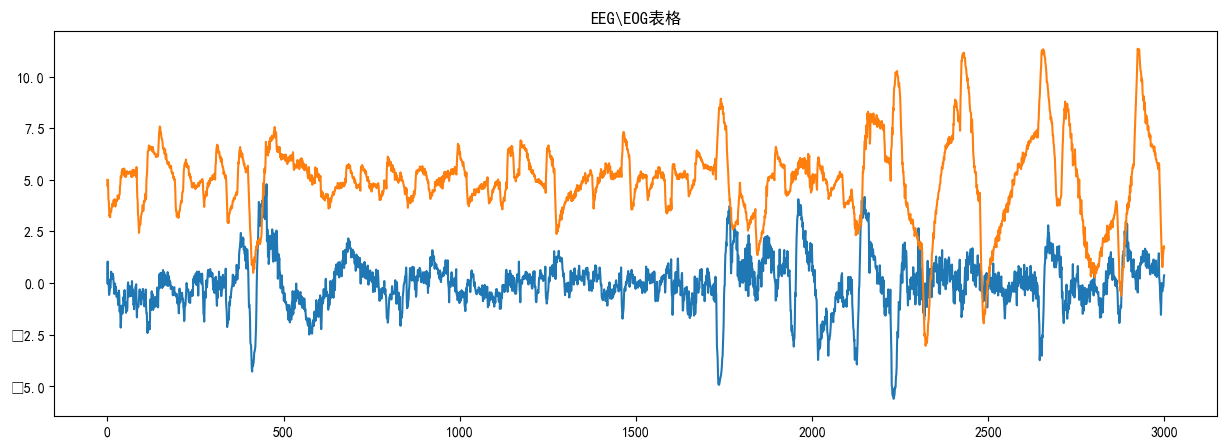

torch.Size([15, 3000])
torch.Size([15, 3000])


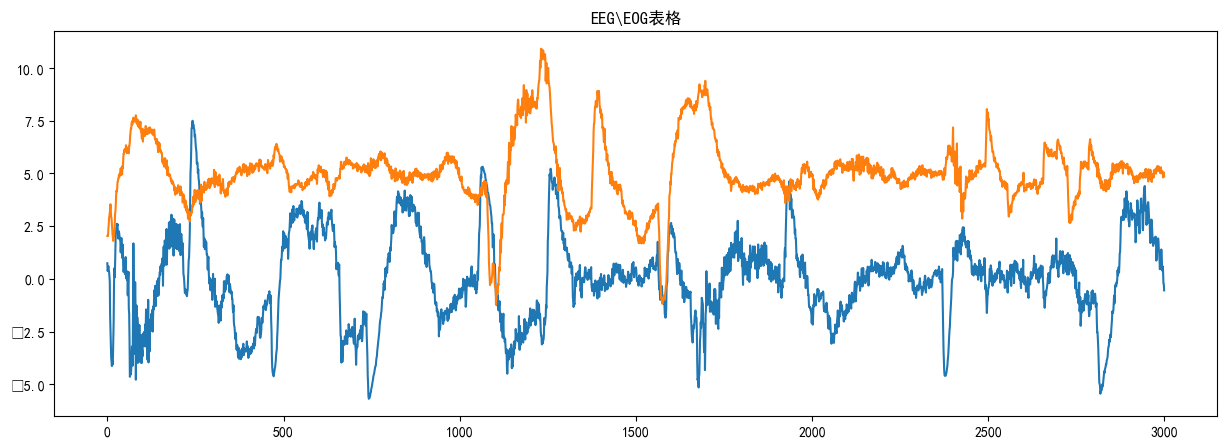

torch.Size([15, 3000])
torch.Size([15, 3000])


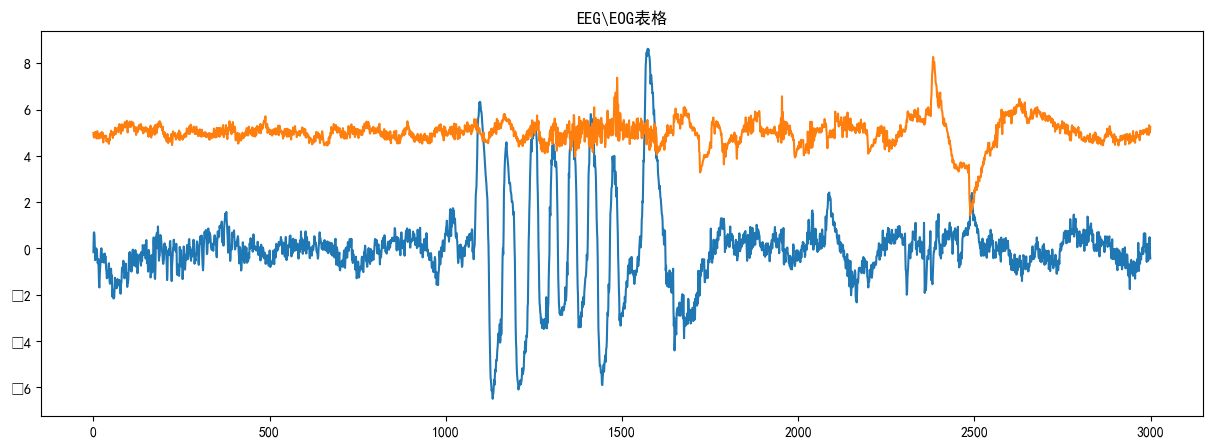

torch.Size([15, 3000])
torch.Size([15, 3000])


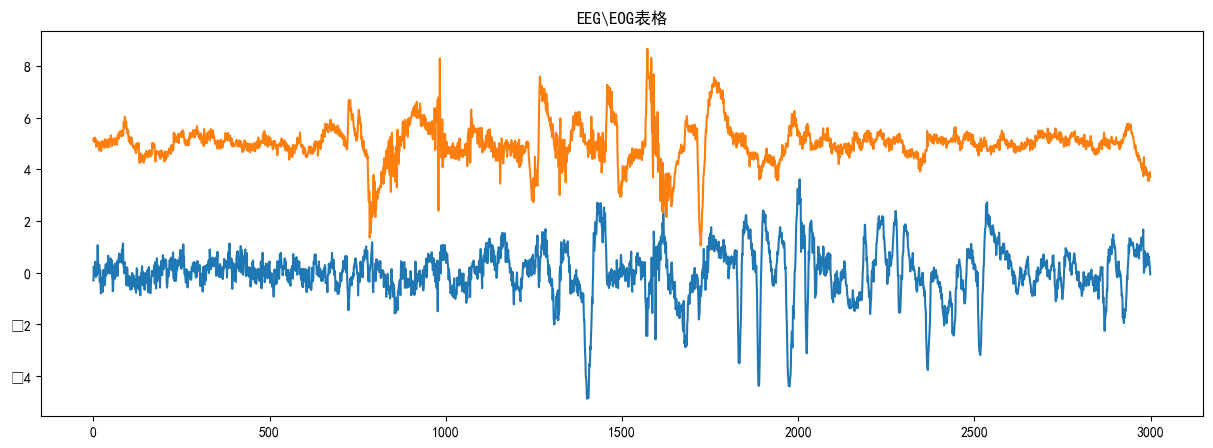

torch.Size([15, 3000])
torch.Size([15, 3000])


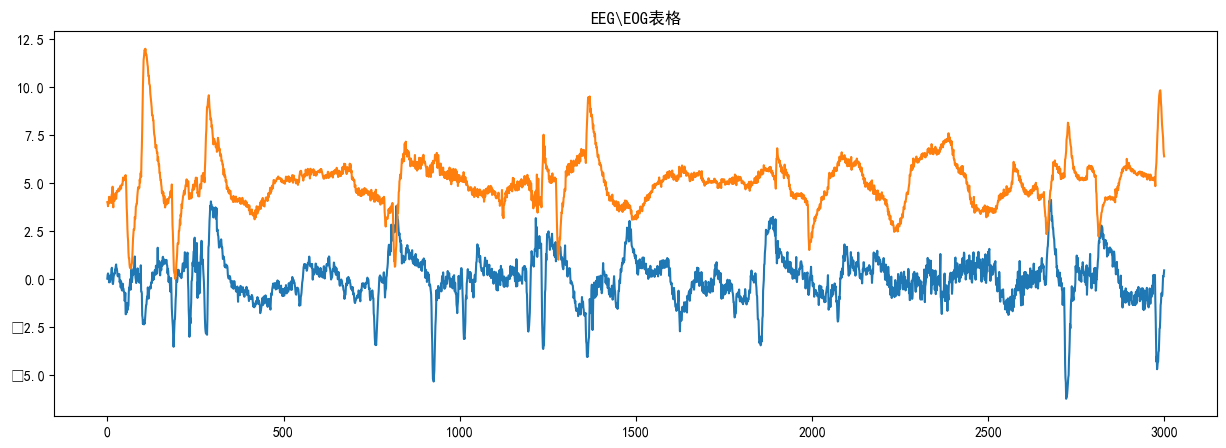

torch.Size([15, 3000])
torch.Size([15, 3000])


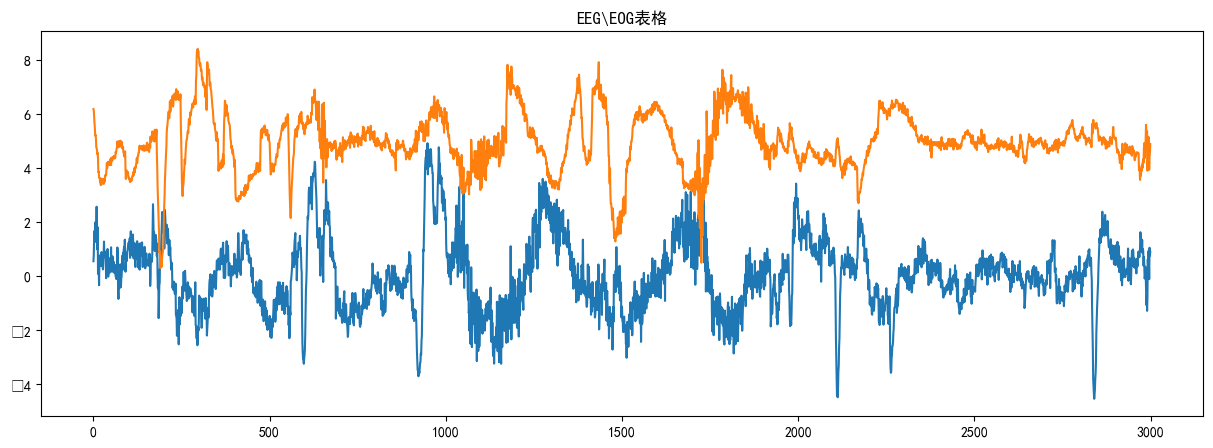

torch.Size([15, 3000])
torch.Size([15, 3000])


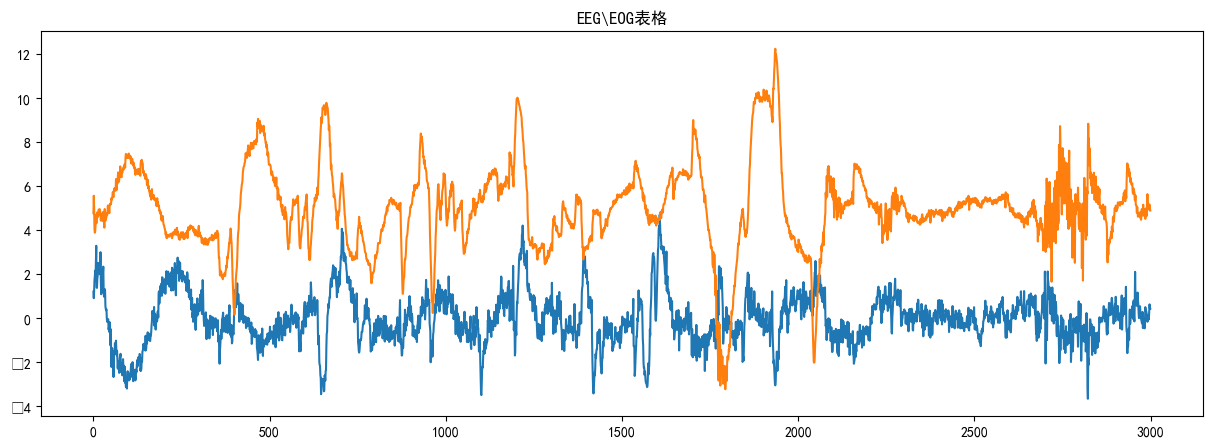

torch.Size([15, 3000])
torch.Size([15, 3000])


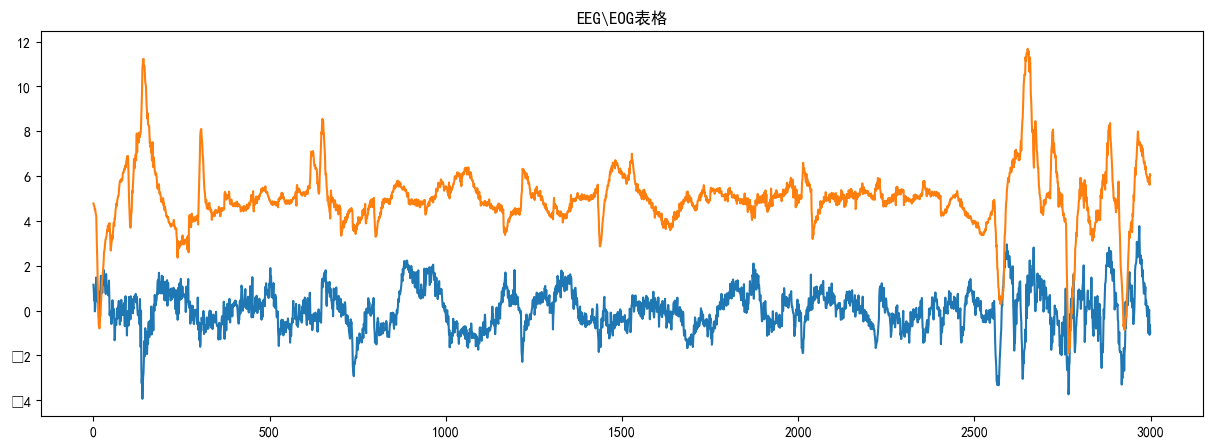

torch.Size([15, 3000])
torch.Size([15, 3000])


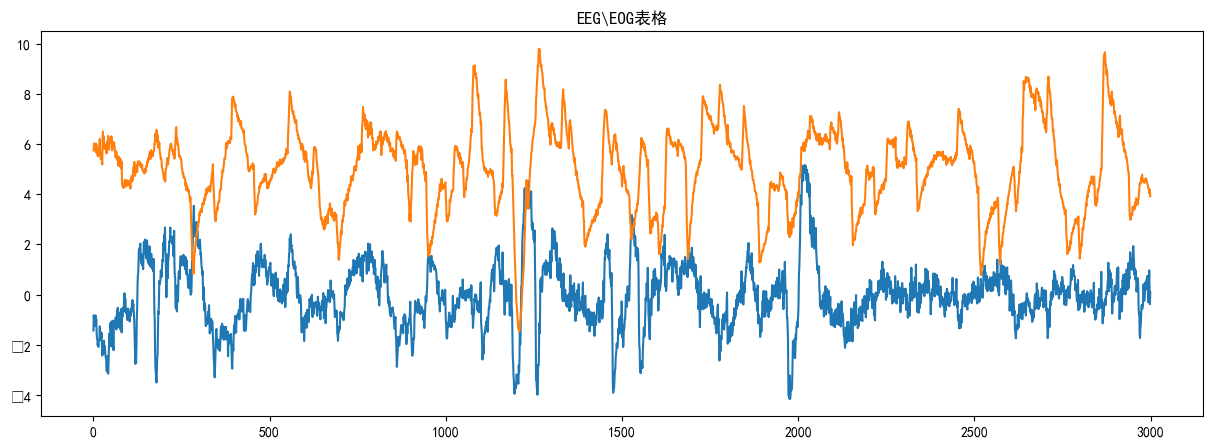

torch.Size([15, 3000])
torch.Size([15, 3000])


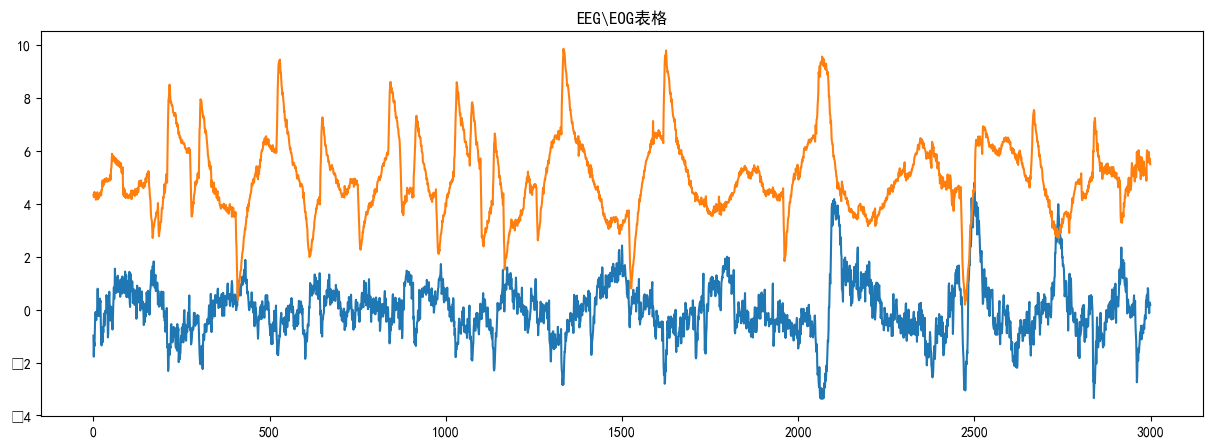

torch.Size([15, 3000])
torch.Size([15, 3000])


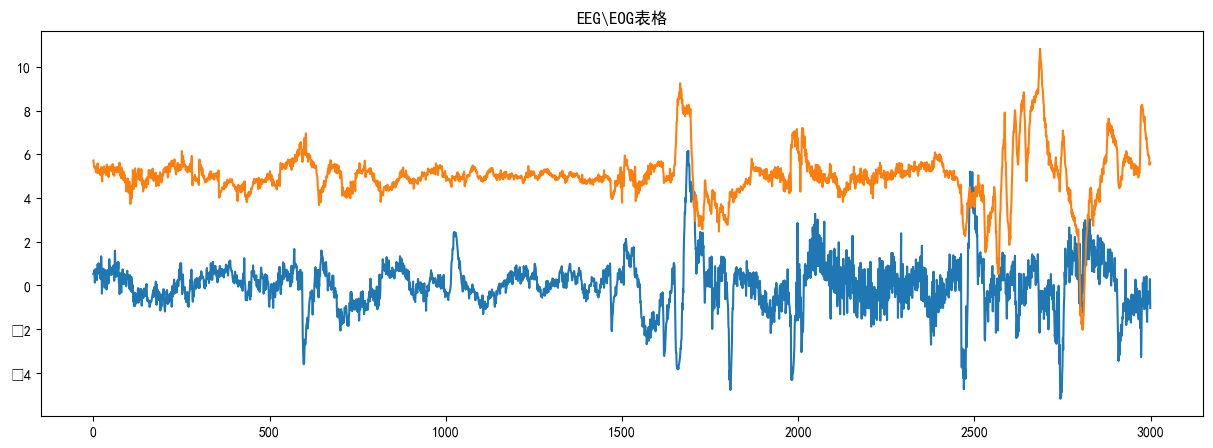

torch.Size([15, 3000])
torch.Size([15, 3000])


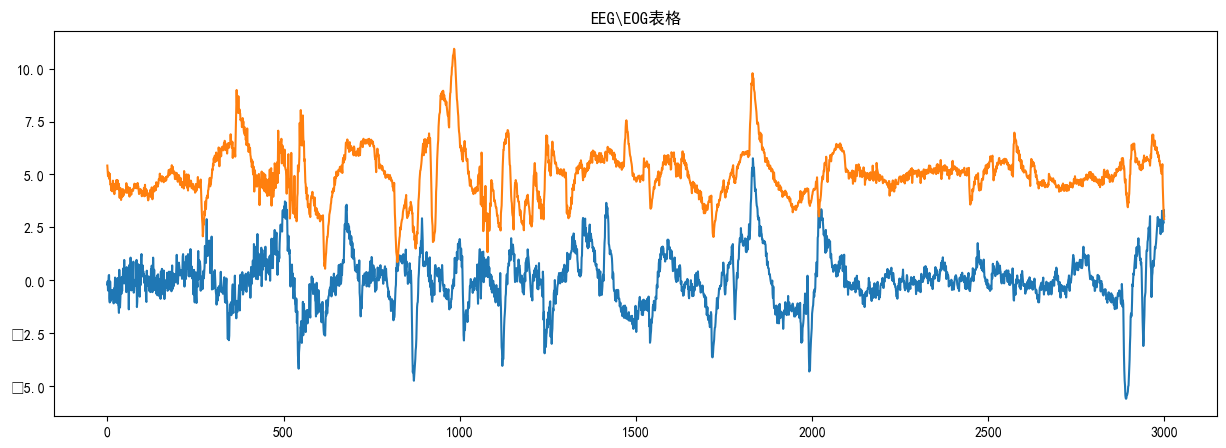

torch.Size([15, 3000])
torch.Size([15, 3000])


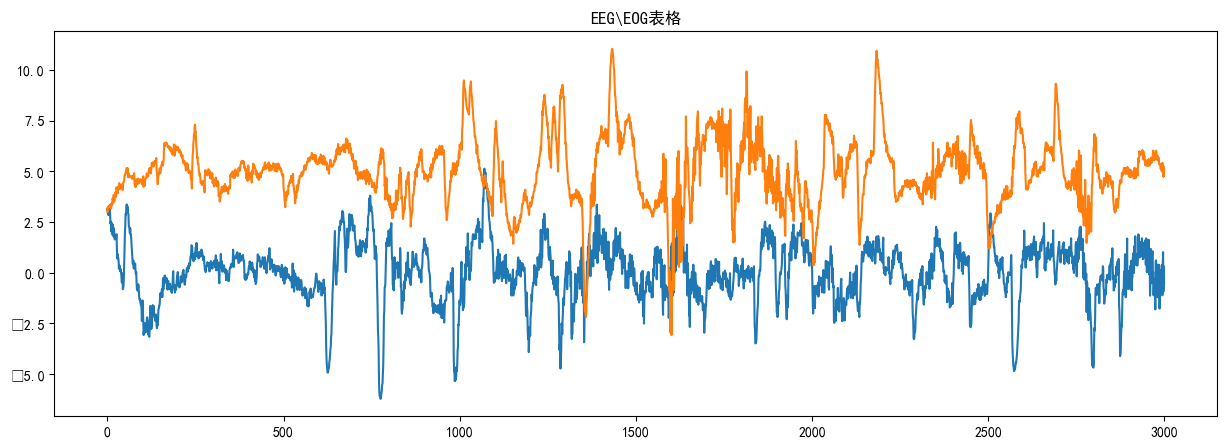

torch.Size([15, 3000])
torch.Size([15, 3000])


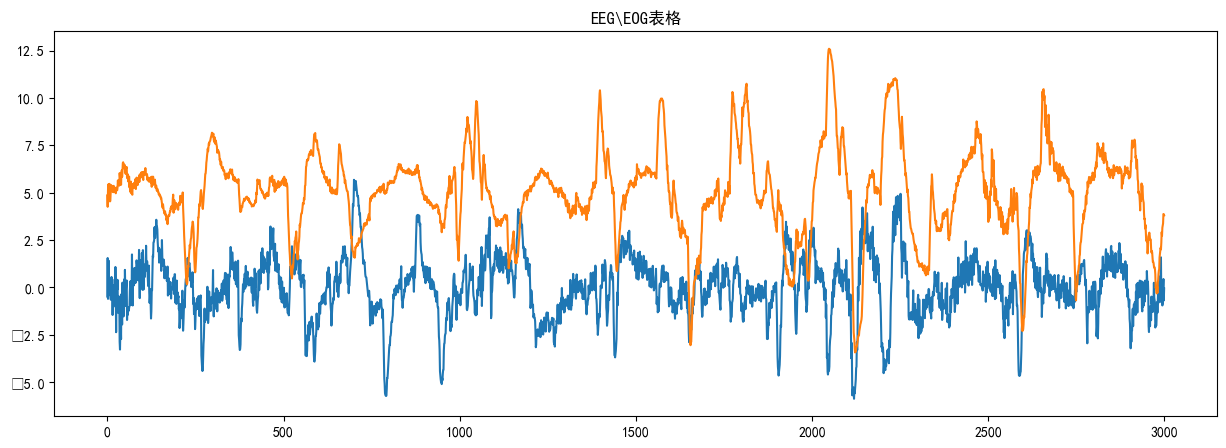

torch.Size([15, 3000])
torch.Size([15, 3000])


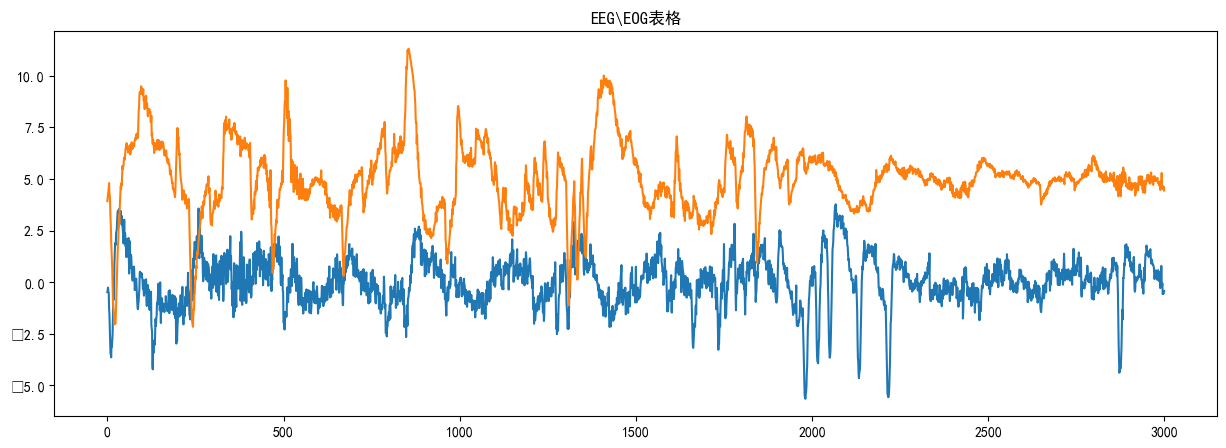

4049867
predicting 0
predicting 1
predicting 2
predicting 3
predicting 4
predicting 5
predicting 6
predicting 7
predicting 8
predicting 9
predicting 10
predicting 11
predicting 12
predicting 13
predicting 14
torch.Size([30, 5])
start epoch:  1294
EEG batch shape: torch.Size([15, 1, 15, 3000])
EOG batch shape: torch.Size([15, 1, 15, 3000])


IndexError: index 1294 is out of bounds for dimension 0 with size 15

In [6]:

infer_dataset = SleepEDF_Seq_MultiChan_Dataset_Inference(eeg_file=eeg1_1,
                                                         eog_file=eog_1,
                                                         # label_file=labels_1,
                                                         device=device, mean_eeg_l=eeg1_m1, sd_eeg_l=eeg1_std1,
                                                         mean_eog_l=eog_m1, sd_eog_l=eog_std1,
                                                         sub_wise_norm=True, num_seq=num_seq,
                                                         transform=transforms.Compose([
                                                             transforms.ToTensor()
                                                         ]))

infer_data_loader = data.DataLoader(infer_dataset, batch_size=1, shuffle=False)  # 16
len(infer_data_loader)

eeg_data, eog_data= next(iter(infer_data_loader))
print(f"EEG batch shape: {eeg_data.size()}")
print(f"EOG batch shape: {eog_data.size()}")
# print(f"EMG batch shape: {eeg2_data.size()}")
# print(f"Labels batch shape: {label.size()}")
for i in range(15):
    eeg_data_temp = eeg_data[0].squeeze()  # (0)
    eog_data_temp = eog_data[0].squeeze()  # (0)

    print(eeg_data_temp.shape)
    print(eog_data_temp.shape)
    t = np.arange(0, 30, 1 / 100)
    plt.figure(figsize=(15, 5))
    plt.plot(eeg_data_temp[i].squeeze())
    plt.plot(eog_data_temp[i].squeeze() + 5)
    plt.title(f"EEG\EOG表格")
    
    #打印: 第0个Epoch的3000个采样点,橙蓝折线图
    save_dir = f"results/{date.today().strftime('%Y%m%d')}"
    if not  os.path.exists(save_dir): os.makedirs(save_dir)
    save_path = f"results/{date.today().strftime('%Y%m%d')}/read_sample_epoch {i}.jpg"
    plt.savefig(save_path,dpi=300)
    plt.show()# show放在savefig前会输出空白图片,这里修改了

#Load Model
from models.sequence_cmt import Seq_Cross_Transformer_Network  # as Seq_Cross_Transformer_Network
from models.sequence_cmt import Epoch_Cross_Transformer
from models.model_blocks import PositionalEncoding, Window_Embedding, Intra_modal_atten, Cross_modal_atten, Feed_forward

# Download the model checkpoint
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Y6yPH8XyVLTVY0Wbp8o6qcDWAv9n_NPG' -O 'checkpoint_model_best_acc.pth.tar'

test_model = torch.load('./checkpoint_model_best_acc.pth.tar', map_location=device)
test_model.eval()
print(sum(p.numel() for p in test_model.parameters() if p.requires_grad))

"""# Get Predictions for the Subject"""

import warnings

warnings.filterwarnings("ignore")

# feat_main = []
pred_val_main = torch.zeros((len(infer_data_loader) + num_seq, 1, 5))  # data, output,seq pred,
labels_val_main = torch.zeros((len(infer_data_loader) + num_seq, 1))  # data, output,seq pred,
first = 0
m = torch.nn.Softmax()
with torch.no_grad():  # 确保在接下来的代码块中不会计算梯度
    test_model.eval()  # 将模型设置为评估模式，这对于推断是必要的
    for batch_val_idx, data_val in enumerate(infer_data_loader):  # 遍历数据加载器中的每个批次
        if batch_val_idx % 1 == 0: print("predicting", batch_val_idx)
        val_eeg, val_eog = data_val  # 从批次数据中解包EEG、EOG信号和标签
        pred, _ = test_model(val_eeg.float().to(device), val_eog.float().to(device))  # 使用模型进行预测，忽略返回的第二个值


        # feat_main.append(feat_list)  # 这行代码被注释掉了，它看起来像是用来存储特征的
        for ep in range(num_seq):  # 遍历每个序列
            pred_val_main[batch_val_idx + ep] += m(pred[ep]).cpu()  # 将预测结果累加到pred_val_main数组中，m可能是一个映射函数

# pred_val_main = pred_val_main[num_seq-1:-num_seq]  # 这行代码被注释掉了，它看起来像是要裁剪预测数组
pred_val_main = (pred_val_main / num_seq).squeeze()  # 计算预测的平均值
# labels_val_main = labels_val_main[num_seq-1:-num_seq]  # 这行代码被注释掉了，它看起来像是要裁剪标签数组


print(pred_val_main.shape)  # 打印预测的平均值形状


'''
from utils.metrics import accuracy, kappa, g_mean, plot_confusion_matrix, confusion_matrix

sens_l, spec_l, f1_l, prec_l, sens, spec, f1, prec = confusion_matrix(pred_val_main, labels_val_main,
                                                                      5, labels_val_main.shape[0])

g = g_mean(sens, spec)

acc = accuracy(pred_val_main, labels_val_main)

kap = kappa(pred_val_main, labels_val_main)

print(f"Accuracy {acc}")
print(f"Kappa {kap}")
print(f"Macro F1 Score {f1}")
print(f"G Mean {g}")
print(f"Sensitivity {sens}")
print(f"Specificity {spec}")
print(f"Class wise F1 Score {f1_l}")
'''
"""## Get Interpretations for the Subject"""

infer_data_loader = data.DataLoader(infer_dataset, batch_size=1, shuffle=False)  # 16
batch_size = len(infer_data_loader)
infer_data_loader = data.DataLoader(infer_dataset, batch_size=batch_size, shuffle=False)  # 16

from einops import rearrange
import torch.nn.functional as F
import torch.nn as nn
import math


def atten_interpret(q, k):
    atten_weights = torch.softmax((q @ k.transpose(-2, -1) / math.sqrt(q.size(-1))), dim=-1)
    return atten_weights


t = start_time_point // 30
print("start epoch: ",t)
eeg_data, eog_data = next(iter(infer_data_loader))
print(f"EEG batch shape: {eeg_data.size()}")
print(f"EOG batch shape: {eog_data.size()}")
# print(f"EMG batch shape: {eeg2_data.size()}")
# print(f"Labels batch shape: {label.size()}")

# print(t)
pred, feat_list = test_model(eeg_data[t].unsqueeze(0).float().to(device), eog_data[t].unsqueeze(0).float().to(device))
pred = np.array([i.argmax(-1).item() for i in pred])
# print(label[t], pred)
# print((label[t]-pred).sum())

"""
Structure of feat_list:
15 lists: each for 30s PSG epoch in a sequence
          each contains 3 representations:
            1)Intra modal features of EEG
            2)Intra modal features of EOG
            3) Cross-modal features
Final element in the list contains inter epoch features.
"""

for i in feat_list[:-1]:
    print(i[0].shape, i[1].shape, i[2].shape)

print(feat_list[-1].shape)

label_dict = ['Wake', 'N1', 'N2', 'N3', 'REM']
pred_list = [label_dict[i] for i in pred]
print("pred_list",pred_list)
## 画图 ##
###### Interpreting inter-epoch relationships  ##########
plt.rcParams['axes.linewidth'] = 2
seq_features = feat_list[-1]  ##extracting learned inter-epoch features
# seq_atten = atten_interpret(seq_features.squeeze(),seq_features.squeeze()).squeeze().detach().cpu().numpy()
# print(seq_atten.shape)

# plt.figure()
# plt.imshow(seq_atten)

fig, axs = plt.subplots(15, 1, figsize=(1 * 5, 15 * 8))
### = [] #
seq_atten_list = []  #
for i in range(num_seq):
    seq_atten = atten_interpret(seq_features.squeeze()[i].unsqueeze(0),
                                seq_features.squeeze()).squeeze().detach().cpu().numpy()

    rgba_colors = np.zeros((num_seq, 4))
    rgba_colors[:, 0] = 0  # value of red intensity divided by 256
    rgba_colors[i, 0] = 0.4  # value of red intensity divided by 256
    rgba_colors[:, 1] = 0  # value of green intensity divided by 256
    rgba_colors[:, 2] = 0.4  # value of blue intensity divided by 256
    rgba_colors[i, 2] = 0
    seq_atten = seq_atten / seq_atten.max()

    seq_atten_list.append(seq_atten)  #
    rgba_colors[:, -1] = seq_atten
    axs[i].bar(np.arange(1, 16), seq_atten / seq_atten.max(),  # color ='blue',
               color=rgba_colors, align='center', width=0.8)
    # axs[i//5][i%5].set_title('')
    axs[i].tick_params(axis='x', labelsize=30)  # ,which = 'both')
    axs[i].tick_params(axis='y', labelsize=30)
    axs[i].set_xlabel('Epochs', fontsize=30)
    yticks = axs[i].yaxis.get_major_ticks()
    yticks[0].label1.set_visible(False)

save_path = f"results/{date.today().strftime('%Y%m%d')}/Interpreting inter-epoch relationships.jpg"
plt.savefig(save_path,dpi=300)

###### Interpreting cross-modal relationships  ##########
fig, axs = plt.subplots(15, 1, figsize=(1 * 5, 15 * 10))

cross_atten_list = []  #
from matplotlib.font_manager import FontProperties
my_font = FontProperties(fname='env/simhei.ttf')

for i in range(num_seq):
    cross_features = feat_list[i][-1]  ##extracting learned cross-modal features
    cross_atten = atten_interpret(cross_features.squeeze()[0].unsqueeze(0),
                                  cross_features.squeeze()[1:]).squeeze().detach().cpu().numpy()
    cross_atten_list.append(cross_atten)  #

    rgba_colors = np.zeros((2, 4))
    rgba_colors[:, 0] = 0.4  # value of red intensity divided by 256
    rgba_colors[:, 1] = 0  # value of green intensity divided by 256
    rgba_colors[:, 2] = 0  # value of blue intensity divided by 256
    rgba_colors[:, -1] = cross_atten + 0.1
    axs[i].bar(['EEG', 'EOG'], cross_atten,  # color ='red',
               color=rgba_colors, align='center', width=0.9)
    axs[i].tick_params(axis='x', labelsize=30)  # ,which = 'both')
    axs[i].tick_params(axis='y', labelsize=30)
    axs[i].set_ylim(0, 1.02)
    axs[i].set_xlabel('注意力占比', fontsize=30, fontproperties=my_font)
# 创建文件名，包含当前日期时间

save_path = f"results/{date.today().strftime('%Y%m%d')}/cross-modal relationships.jpg"
plt.savefig(save_path, dpi=300)
# plt.savefig(f'/content/cross_modal_sub_{subject_no}_day_{days}_t_{t}_part_1.pdf',dpi = 300)




from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
def plot_interpret(x, y, dydx, fig, axs_no, signal_type="EEG"):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # plt.figure(figsize = (30,5))
    # plt.figure(figsize=(25,5))
    # plt.plot(x,dydx)
    # plt.title(f"Attention Map for Class {label}  {signal_type} ")
    # plt.xlim(x.min(),x.max())
    # plt.colorbar()

    # fig, axs = plt.subplots(2, 1, sharex=True, sharey=True,figsize = (30,10))

    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(dydx.min(), dydx.max())
    lc = LineCollection(segments, cmap='Reds', norm=norm)
    # Set the values used for colormapping
    lc.set_array(dydx)
    lc.set_linewidth(15)
    line = axs[axs_no[0]][axs_no[1]].add_collection(lc)
    # fig.colorbar(line, ax=axs[axs_no[0]][axs_no[1]])
    # fig.colorbar(line, ax=axs[1])
    # axs[axs_no[0]][axs_no[1]].set_xlabel(f"{signal_type}",fontsize = 100,labelpad = 20)
    axs[axs_no[0]][axs_no[1]].set_title(f'Epoch {i + 1} {signal_type}', fontsize=100)
    # axs[i].set_xlabel('Signal',fontsize = 100)
    # axs[axs_no[0]][axs_no[1]].axis('off')
    # Hide X and Y axes label marks
    axs[axs_no[0]][axs_no[1]].xaxis.set_tick_params(labelbottom=False)
    axs[axs_no[0]][axs_no[1]].yaxis.set_tick_params(labelleft=False)

    # Hide X and Y axes tick marks
    axs[axs_no[0]][axs_no[1]].set_xticks([])
    axs[axs_no[0]][axs_no[1]].set_yticks([])
    axs[axs_no[0]][axs_no[1]].set_xlim(x.min(), x.max())
    axs[axs_no[0]][axs_no[1]].set_ylim(y.min() - 0.2, y.max() + 0.2)
    # show something
    # plt.show()
    # if save_path:
    #     fig.savefig(os.path.join(save_path,f"{signal_type}_{label}"))


from matplotlib.collections import LineCollection

###### Interpreting intra-modal relationships  ##########
    ###### 解释同模态内部关系  ##########
plt.rcParams['axes.linewidth'] = 20
fig, axs = plt.subplots(15, 2, figsize=(2 * 50, 15 * 20))
# seq_features = feat_list[-1]
eeg_atten_list = []  #
eog_atten_list = []  #
for i in range(num_seq):
    eeg_features = feat_list[i][0]  ##extracting learned intra-modal EEG features
    eog_features = feat_list[i][1]  ##extracting learned intra-modal EOG features
    cross_features = feat_list[i][-1]  ##extracting learned cross-modal features

    eeg_atten = atten_interpret(cross_features.squeeze()[0].unsqueeze(0),
                                eeg_features.squeeze()[1:])  # .squeeze().detach().cpu().numpy()
    eog_atten = atten_interpret(cross_features.squeeze()[0].unsqueeze(0),
                                eog_features.squeeze()[1:])  # .squeeze().detach().cpu().numpy()

    eeg_atten = F.upsample(eeg_atten.unsqueeze(0), scale_factor=3000 // 60,
                           mode='nearest').squeeze().detach().cpu().numpy()
    eog_atten = F.upsample(eog_atten.unsqueeze(0), scale_factor=3000 // 60,
                           mode='nearest').squeeze().detach().cpu().numpy()

    eeg_atten_list.append(eeg_atten)  #
    eog_atten_list.append(eog_atten)  #

    t1 = np.arange(0, 30, 1 / 100)
    plot_interpret(t1, eeg_data[t, 0, i, :].squeeze().cpu().numpy(), eeg_atten, fig, [i, 0], signal_type="EEG")
    plot_interpret(t1, eog_data[t, 0, i, :].squeeze().cpu().numpy(), eog_atten, fig, [i, 1], signal_type="EOG")
save_path = f"results/{date.today().strftime('%Y%m%d')}/注意力热力折线图.jpg"
plt.savefig(save_path)



"""# Final plot similar to the paper"""
# fig, axs = plt.subplots(num_seq, 4,figsize=(200, 20*num_seq),gridspec_kw={'width_ratios': [2,2,10,10]}) # for more clear figure
fig, axs = plt.subplots(num_seq, 4, figsize=(120, 20 * num_seq), gridspec_kw={'width_ratios': [2, 2, 10, 10]})
title_font_size = fig.dpi * 0.2
label_font_size = fig.dpi * 0.1
for i in range(num_seq):
    # Plotting inter-epoch attention ##############################
    rgba_colors = np.zeros((num_seq, 4))
    rgba_colors[:, 0] = 0  # value of red intensity divided by 256
    rgba_colors[i, 0] = 0.4  # value of red intensity divided by 256
    rgba_colors[:, 1] = 0  # value of green intensity divided by 256
    rgba_colors[:, 2] = 0.4  # value of blue intensity divided by 256
    rgba_colors[i, 2] = 0
    rgba_colors[:, -1] = seq_atten_list[i]
    axs[i][0].bar(np.arange(1, num_seq + 1), seq_atten_list[i] / seq_atten_list[i].max(),
                  # /seq_attn[i].max(),# color ='blue',
                  color=rgba_colors, align='center')
    # axs[i//5][i%5].set_title('')
    axs[i][0].tick_params(axis='x', labelsize=label_font_size)
    axs[i][0].tick_params(axis='y', labelsize=label_font_size)
    axs[i][0].set_xlabel('Epochs', fontsize=title_font_size)
    yticks = axs[i][0].yaxis.get_major_ticks()
    yticks[0].label1.set_visible(False)

    # Plotting cross-modal attention ##############################
    rgba_colors = np.zeros((2, 4))
    rgba_colors[:, 0] = 0.4  # value of red intensity divided by 256
    rgba_colors[:, 1] = 0  # value of green intensity divided by 256
    rgba_colors[:, 2] = 0  # value of blue intensity divided by 256
    rgba_colors[:, -1] = cross_atten_list[i]
    axs[i][1].bar(['EEG', 'EOG'], cross_atten_list[i],  # color ='red',
                  color=rgba_colors, align='center')
    axs[i][1].tick_params(axis='x', labelsize=label_font_size)
    axs[i][1].tick_params(axis='y', labelsize=label_font_size)
    axs[i][1].set_ylim(0, 1.02)
    axs[i][1].set_xlabel('Signal', fontsize=title_font_size)

    # # Plotting EEG attention ##############################
    eeg_atten_epoch = eeg_atten_list[i]
    t1 = np.arange(0, 3000, 1)
    plot_interpret(t1, eeg_data[t, 0, i, :].squeeze().cpu().numpy(), eeg_atten, fig, [i, 2],
                   signal_type=f"EEG Class:{pred_list[i]}")

    # plot_interpret(t1,eog_data[t,0,i,:].squeeze().cpu().numpy(),eog_atten,fig,[i,1],signal_type = "EOG")

    # # Plotting EOG attention ##############################
    eog_atten_epoch = eog_atten[i]
    plot_interpret(t1, eog_data[t, 0, i, :].squeeze().cpu().numpy(), eog_atten, fig, [i, 3],
                   signal_type=f"EOG Class:{pred_list[i]}")

# time = [int(record_id.split('-')[1].split('_')[i]) for i in range(num_epoch_seq)]
# plt.subplots_adjust(wspace=0.2)
fig.suptitle('Interpretation for patient '+str(subject_no)+' for 30s epochs from '+str(start_time_point)+'s',fontsize = title_font_size*2)
save_path = f"results/{date.today().strftime('%Y%m%d')}/睡眠时期可解释性分析.jpg"
plt.savefig(save_path,dpi=100)
plt.show()
